In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/home/keithyamkf/jupyter-notebook/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [3]:
cpu_count()

4

### Begin

In [4]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/clean_10yr_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0007.HK,0008.HK,0010.HK,0011.HK,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,59.858372,42.464977,5.838195,8.589485,49.812798,27.253111,0.75,1.905828,41.102428,83.984497,...,6.521324,1.048637,13.701911,13.843930,2.338585,0.45159,1.156469,2.118294,1.380821,0.266212
2011-01-04,60.620258,42.232571,5.850851,8.603373,49.968369,27.280636,0.73,1.922302,41.141720,83.855309,...,6.826671,1.048637,13.493793,14.016541,2.355491,0.45159,1.184907,2.111633,1.417399,0.268489
2011-01-05,61.286934,42.431778,5.844519,8.506300,51.181801,27.308163,0.72,1.894841,41.338200,85.341171,...,6.870292,1.048637,13.528478,14.051094,2.338585,0.43869,1.197547,2.198230,1.417399,0.266144


In [5]:
train_start = '2011-01-01'
train_end = '2011-12-31'
dataset = dataset[train_start:train_end]
#
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)
#
comb_df.dropna(axis=0, how='any', inplace=True)
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [12]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    return data

### Verify Linear regression

    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }

In [6]:
stock1 = '0266.HK.prev'
stock2 = '0952.HK'

In [7]:
prevday_returns[stock1]

Date
2011-01-05    0.013964
2011-01-06    0.000000
2011-01-07   -0.024962
2011-01-10    0.024962
2011-01-11    0.009203
                ...   
2011-12-22    0.000000
2011-12-23    0.000000
2011-12-28    0.000000
2011-12-29    0.000000
2011-12-30    0.000000
Name: 0266.HK.prev, Length: 243, dtype: float64

In [8]:
today_returns[stock2]

Date
2011-01-05    0.000000
2011-01-06   -0.038235
2011-01-07    0.000000
2011-01-10    0.025643
2011-01-11   -0.038701
                ...   
2011-12-22    0.000000
2011-12-23    0.000000
2011-12-28    0.000000
2011-12-29    0.024690
2011-12-30    0.000000
Name: 0952.HK, Length: 243, dtype: float64

In [9]:
X = prevday_returns[stock1].copy()
X = sm.add_constant(X)
y = today_returns[stock2]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

Params 2.6379 TValues 12.0129 RSquared 0.3745


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Find other related pairs

In [12]:
# result_df = pd.read_csv('../data/regression_pair.csv', index_col=0)
result_df = pd.read_csv('../data/10yr_regression_pair.csv', index_col=0)
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
106223,0266.HK.prev,0952.HK,2.637893,12.012917,0.374530
79435,0202.HK.prev,2323.HK,0.319674,10.792716,0.325842
504446,6823.HK.prev,0720.HK,-0.164456,10.635044,0.319409
146711,0373.HK.prev,1003.HK,1.269368,10.366868,0.308409
94429,0237.HK.prev,6823.HK,4.017138,8.961810,0.249955
100645,0252.HK.prev,1223.HK,0.355493,8.581045,0.234031
100294,0252.HK.prev,0335.HK,0.531830,7.466439,0.187862
110674,0273.HK.prev,2319.HK,0.088088,7.230479,0.178259
51850,0128.HK.prev,0026.HK,0.084212,7.148107,0.174927
110307,0273.HK.prev,0526.HK,-0.140535,6.826599,0.162038


In [15]:
result_df[result_df['Today']=='0952.HK'].sort_values(by='RSquared', ascending=False)

,Prev,Today,Params,TValues,RSquared
106223,0266.HK.prev,0952.HK,2.637893,12.012917,3.745299e-01
79243,0202.HK.prev,0952.HK,0.223215,4.936241,9.182199e-02
92023,0230.HK.prev,0952.HK,0.486560,4.636106,8.188194e-02
444894,2323.HK.prev,0952.HK,0.368802,4.534547,7.861274e-02
341234,1085.HK.prev,0952.HK,0.354436,4.278952,7.060844e-02
...,...,...,...,...,...
314964,0981.HK.prev,0952.HK,-0.001040,0.010294,4.397340e-07
319224,0995.HK.prev,0952.HK,0.000272,0.001824,1.380539e-08
339814,1076.HK.prev,0952.HK,0.000000,NaN,-2.220446e-16
362534,1159.HK.prev,0952.HK,0.000000,NaN,-2.220446e-16


### Experiment Multiple Independent Variables

In [16]:
indp_variables = ['0266.HK.prev', '0202.HK.prev', '0230.HK.prev']
dep_variable = '0952.HK'

In [17]:
X = prevday_returns[indp_variables].copy()
X = sm.add_constant(X)
y = today_returns[dep_variable]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

Params 2.3561 TValues 10.1368 RSquared 0.4016


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Find different combinations of Independent Variables

In [18]:
filtered_df = result_df[result_df['Today']=='0952.HK'].sort_values(by='RSquared', ascending=False)

In [19]:
dep_variable = '0952.HK'
indp_rsq_ls = list()
for i in range(1,200):
    indp_variables = filtered_df['Prev'].to_list()[:i]
    X = prevday_returns[indp_variables].copy()
    X = sm.add_constant(X)
    y = today_returns[dep_variable]
    model = sm.OLS(y, X).fit()
    #
    outcome_dict = {
        'no_var' : i,
        'rsquared' : model.rsquared
    }
    indp_rsq_ls.append(outcome_dict)
    #
    print(indp_variables)
    print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['0266.HK.prev']
Params 2.6379 TValues 12.0129 RSquared 0.3745
['0266.HK.prev', '0202.HK.prev']
Params 2.4657 TValues 10.9084 RSquared 0.3928
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev']
Params 2.3561 TValues 10.1368 RSquared 0.4016
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev']
Params 2.2591 TValues 9.6546 RSquared 0.4150
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev']
Params 2.1627 TValues 9.2145 RSquared 0.4299
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev']
Params 2.0862 TValues 8.9245 RSquared 0.4458
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev']
Params 2.0631 TValues 8.8573 RSquared 0.4536
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev']
Params 1.8916 TValues 7.9437 RSquared 0.4706
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '232

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev']
Params 1.5951 TValues 6.8018 RSquared 0.6263
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev']
Params 1.3798 TValues 5.8611 RSquared 0.7006
['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

['0266.HK.prev', '0202.HK.prev', '0230.HK.prev', '2323.HK.prev', '1085.HK.prev', '0406.HK.prev', '0370.HK.prev', '0610.HK.prev', '0385.HK.prev', '0916.HK.prev', '1104.HK.prev', '0943.HK.prev', '0285.HK.prev', '3336.HK.prev', '0271.HK.prev', '0601.HK.prev', '0679.HK.prev', '1006.HK.prev', '0432.HK.prev', '0213.HK.prev', '0666.HK.prev', '1120.HK.prev', '0294.HK.prev', '0332.HK.prev', '0120.HK.prev', '0219.HK.prev', '3900.HK.prev', '0661.HK.prev', '2302.HK.prev', '0020.HK.prev', '0823.HK.prev', '3303.HK.prev', '0825.HK.prev', '0281.HK.prev', '0152.HK.prev', '0373.HK.prev', '0970.HK.prev', '0838.HK.prev', '1138.HK.prev', '2883.HK.prev', '0335.HK.prev', '0136.HK.prev', '0775.HK.prev', '0216.HK.prev', '0701.HK.prev', '1164.HK.prev', '0617.HK.prev', '1918.HK.prev', '0113.HK.prev', '0050.HK.prev', '1045.HK.prev', '0007.HK.prev', '1129.HK.prev', '3398.HK.prev', '1777.HK.prev', '1838.HK.prev', '0908.HK.prev', '0547.HK.prev', '0726.HK.prev', '0941.HK.prev', '0529.HK.prev', '0169.HK.prev', '0355.H

In [21]:
indp_rsq_df = pd.DataFrame(indp_rsq_ls)
indp_rsq_df

,no_var,rsquared
0,1,0.374530
1,2,0.392850
2,3,0.401575
3,4,0.415010
4,5,0.429877
...,...,...
194,195,0.919685
195,196,0.921093
196,197,0.921094
197,198,0.922976


In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_two_stocks(dep_variable, x, y):
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.set_xlabel('Number of independent variables')
    ax.set_ylabel('R Squared')
    ax.set_title('Dependent Variable : {}'.format(dep_variable))
    ax.plot(x, y)  # Plot some data on the axes.

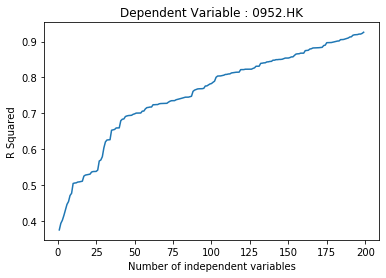

In [23]:
plot_two_stocks(dep_variable, indp_rsq_df['no_var'], indp_rsq_df['rsquared'])

### Plot other pair

In [ ]:
stock1 = '2892.HK.prev'
stock2 = '1121.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, start)

### Upload to AWS S3

In [24]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.upload_data_to_s3(s3_bucket, local_path)